
# Clasificación de texto - Modelo de apoyo para detección de noticias falsas

# Caso 2

- Eduardo Puraivan eduardo.puraivan@postgrado.uv.cl.
- Eduardo Godoy eduardo.godoy@postgrado.uv.cl. <br>
**Estudiantes de doctorado en Ingeniería Informática Aplicada** 

## Profesor:
- Rodrigo Salas.
## Asignatura:
- Redes Neuronales y apredizaje profundo.

In [1]:
import numpy as np

#import tensorflow_datasets as tfds
import tensorflow as tf

#tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
import pandas as pd
df = pd.read_csv("input/data_set.csv", sep='|')
#df = pd.read_excel("input/HILab-Fake_News_Detection_For_Hong_Kong_Tweets.xlsx")
df.head()

,text,num_words,num_syllables,num_sentences,readability,avg_words_in_sentences,avg_syllables_per_word,num_big_words,num_short_sentences,num_urls,polarity,subjectibity,class
0,WASHINGTON (Reuters) - The head of a conservat...,836,1312,42,53.862,5.216288,1.6,212,1,0,0.037083,0.410250,real
1,WASHINGTON (Reuters) - Transgender people will...,647,1121,26,34.998,5.533654,1.7,206,0,0,0.055880,0.298557,real
2,WASHINGTON (Reuters) - The special counsel inv...,484,749,19,50.059,5.085339,1.5,124,1,0,0.115930,0.316798,real
3,WASHINGTON (Reuters) - Trump campaign adviser ...,395,672,19,41.807,5.545213,1.7,121,1,0,0.035968,0.306569,real
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,905,1424,42,51.848,5.095070,1.6,233,3,0,0.030093,0.399891,real


In [4]:
df = df[pd.notnull(df['text'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44267 entries, 0 to 44266
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   text                    44267 non-null  object 
 1   num_words               44267 non-null  int64  
 2   num_syllables           44267 non-null  int64  
 3   num_sentences           44267 non-null  int64  
 4   readability             44267 non-null  float64
 5   avg_words_in_sentences  44267 non-null  float64
 6   avg_syllables_per_word  44267 non-null  float64
 7   num_big_words           44267 non-null  int64  
 8   num_short_sentences     44267 non-null  int64  
 9   num_urls                44267 non-null  int64  
 10  polarity                44267 non-null  float64
 11  subjectibity            44267 non-null  float64
 12  class                   44267 non-null  object 
dtypes: float64(5), int64(6), object(2)
memory usage: 4.7+ MB


Initially this returns a dataset of (text, label pairs):

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn

col = ['text', 'class']
df = df[col]
df.columns = ['text', 'class']
df['class'] = LabelEncoder().fit_transform(df['class'] .values)
df.head()

df_sh = sklearn.utils.shuffle(df)
Y = df_sh['class']
X = df_sh['text']


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
print(len(y_train))
print(len(y_test))

train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_train.values, tf.string),
            tf.cast(y_train.values, tf.int32)
        )
    )
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_test.values, tf.string),
            tf.cast(y_test.values, tf.int32)
        )
    )
)


30986
13281


In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

## Create the text encoder

In [8]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:100]

array(['', '[UNK]', 'the', 'to', 'of', 'a', 'and', 'in', 'that', 'on',
       's', 'for', 'is', 'said', 'he', 'it', 'with', 'was', 'trump', 'as',
       'by', 'his', 'has', 'be', 'have', 'not', 'from', 'this', 'at',
       'are', 'who', 'an', 'they', 'us', 'but', 'we', 'would', 'i',
       'president', 'about', 'will', 'their', 'had', 'you', 't', 'been',
       'were', 'people', 'or', 'more', 'which', 'she', 'her', 'after',
       'one', 'if', 'out', 'all', 'what', 'state', 'its', 'when', 'also',
       'new', 'up', 'there', 'reuters', 'no', 'over', 'donald', 'our',
       'house', 'government', 'can', 'clinton', 'states', 'than', 'so',
       'other', 'obama', 'just', 'some', 'republican', 'him', 'could',
       'united', 'told', 'into', 'white', 'like', 'do', 'against',
       'because', 'campaign', 'them', 'last', 'any', 'news', 'two',
       'election'], dtype='<U15')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [10]:
encoded_example = encoder(X.values)[:3].numpy()
encoded_example

array([[66,  5,  1, ...,  0,  0,  0],
       [65, 10, 67, ...,  0,  0,  0],
       [ 1, 66,  2, ...,  0,  0,  0]], dtype=int64)

With the default settings, the process is not completely reversible. There are three main reasns for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

# Creación del Modelo



1. Este modelo se puede construir como un `tf.keras.Sequential`.

1. La primera capa es el "codificador", que convierte el texto en una secuencia de índices de tokens.

2. Después del codificador hay una capa de incrustación. Una capa de incrustación almacena un vector por palabra. Cuando se llama, convierte las secuencias de índices de palabras en secuencias de vectores. Estos vectores se pueden entrenar. Después del entrenamiento (con suficientes datos), las palabras con significados similares a menudo tienen vectores similares.

  Esta búsqueda de índice es mucho más eficiente que la operación equivalente de pasar un vector codificado en caliente a través de una capa `tf.keras.layers.Dense`.

3. Una red neuronal recurrente (RNN) procesa la entrada de secuencia iterando a través de los elementos. Los RNN pasan las salidas de un paso de tiempo a su entrada en el siguiente paso de tiempo.

  La envoltura `tf.keras.layers.Bidirectional` también se puede utilizar con una capa RNN. Esto propaga la entrada hacia adelante y hacia atrás a través de la capa RNN y luego concatena la salida final.

  * La principal ventaja de un RNN bidireccional es que la señal desde el principio de la entrada no necesita procesarse hasta el final en cada paso de tiempo para afectar la salida.

  * La principal desventaja de un RNN bidireccional es que no puede transmitir predicciones de manera eficiente a medida que se agregan palabras al final.
  
4. Una vez que el RNN ha convertido la secuencia en un solo vector, las dos "capas. Densas" realizan un procesamiento final y convierten esta representación vectorial en un solo logit como resultado de la clasificación.


## Capas LSTM

Las capas recurrentes de Keras tienen dos modos disponibles que están controlados por el argumento del constructor `return_sequences`:

* Si es "False", devuelve solo la última salida para cada secuencia de entrada (un tensor de forma 2D (tamaño_de_lote, características_de_salida)). Este es el predeterminado, utilizado en el modelo anterior.

* Si es "Verdadero", se devuelven las secuencias completas de salidas sucesivas para cada paso de tiempo (un tensor 3D de forma "(tamaño_de_lote, pasos de tiempo, características de salida)").

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [13]:
history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/2
485/485 [==============================] - 7982s 16s/step - loss: 0.4747 - accuracy: 0.7931 - val_loss: 0.0202 - val_accuracy: 0.9958
Epoch 2/2
485/485 [==============================] - 8641s 18s/step - loss: 0.0199 - accuracy: 0.9963 - val_loss: 0.0104 - val_accuracy: 0.9984


In [14]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

208/208 [==============================] - 572s 3s/step - loss: 0.0109 - accuracy: 0.9982
Test Loss: 0.010883754119277
Test Accuracy: 0.9981929063796997


In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

array([[0.01289636]], dtype=float32)

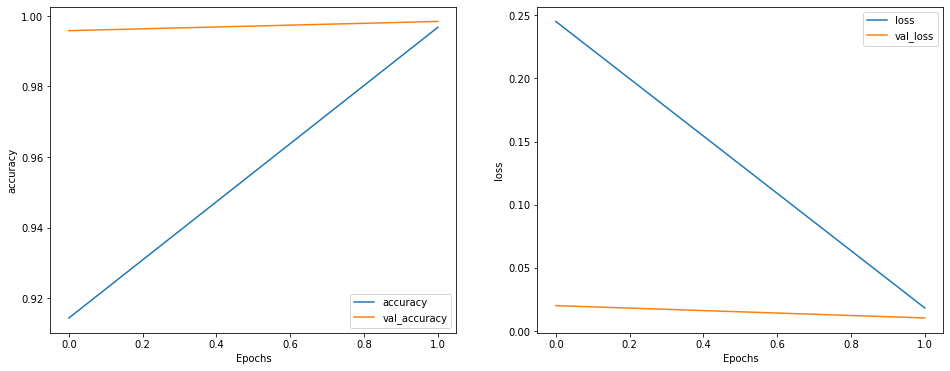

In [16]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

In [17]:
x_test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_test, tf.string)
        )
    )
)
Y_pred = model.predict(X_test)

Y_pred_arr = []
for obj in Y_pred :   
    if(obj[0].astype(float) > 0.5) :
        Y_pred_arr.append(1.0)
    else :
        Y_pred_arr.append(0.0)
    
#Y_pred_arr = np.array(Y_pred_arr).astype(float)
Y_pred_arr[:10]

[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [18]:
Y_test_arr = []
for obj in np.array(y_test) :   
    Y_test_arr.append(obj.astype(float))
Y_test_arr[:10]

[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [19]:
from sklearn.metrics import confusion_matrix
print (confusion_matrix(Y_pred_arr,  Y_test_arr))

[[6826   16]
 [   8 6431]]


In [20]:
from sklearn.metrics import classification_report
print(classification_report(Y_pred_arr,  Y_test_arr))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6842
         1.0       1.00      1.00      1.00      6439

    accuracy                           1.00     13281
   macro avg       1.00      1.00      1.00     13281
weighted avg       1.00      1.00      1.00     13281

